In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
#from cuml import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

train_data = pd.read_csv("SalaryData_Train(1).csv")
test_data = pd.read_csv("SalaryData_Test(1).csv")

combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Removing all the NAs
combined_data = combined_data.dropna()

numerical_features = ['age', 'educationno', 'capitalgain', 'capitalloss', 'hoursperweek']

categorical_columns = ['workclass', 'education', 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'native']

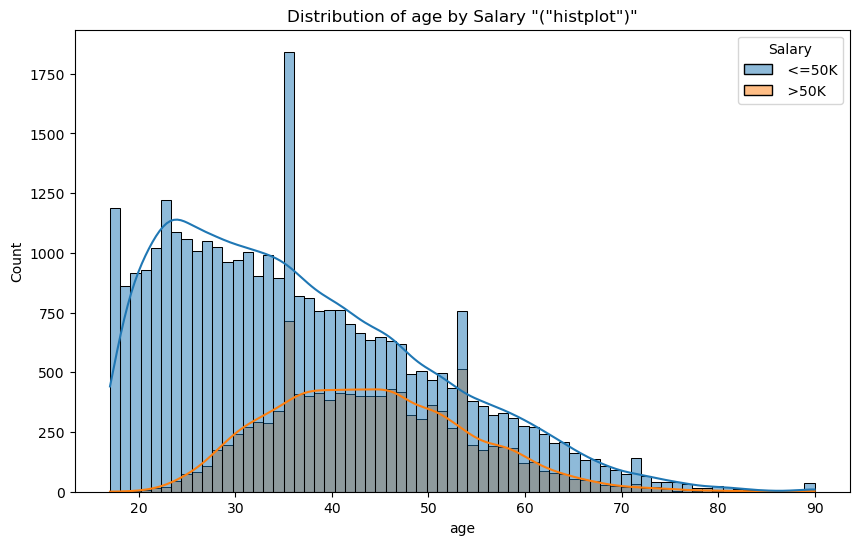

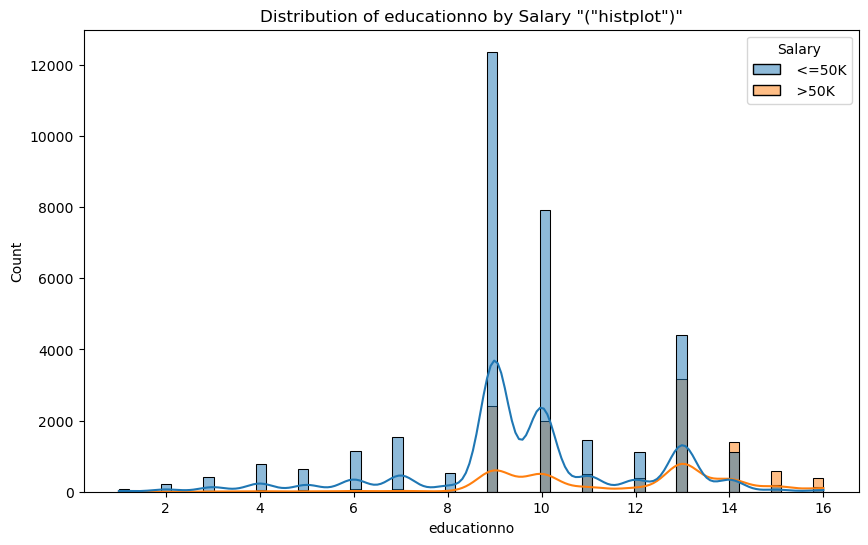

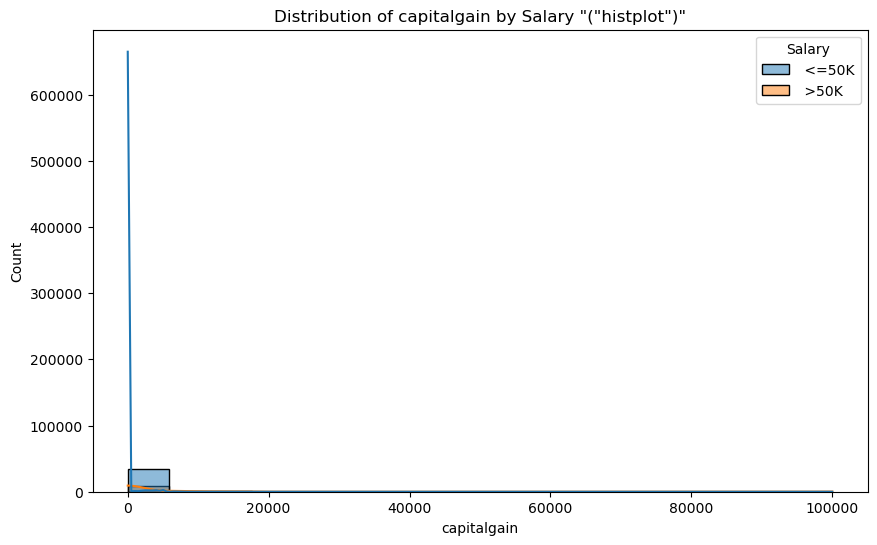

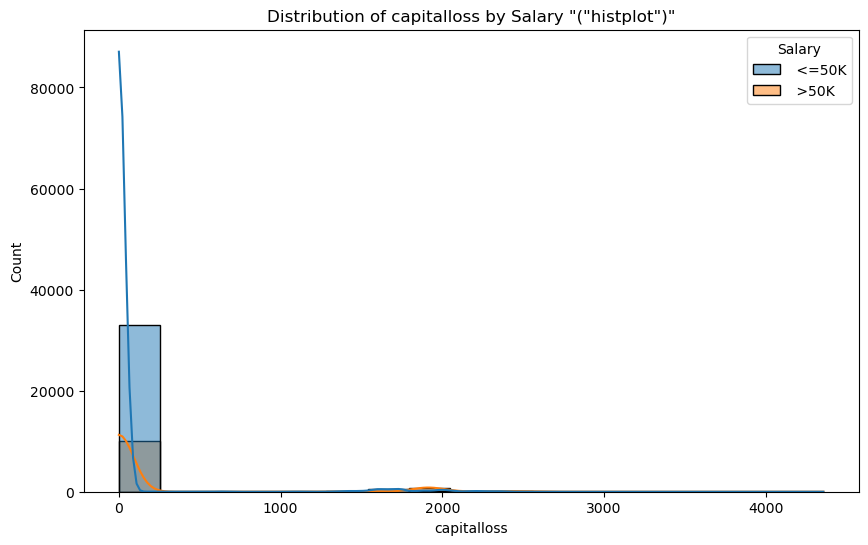

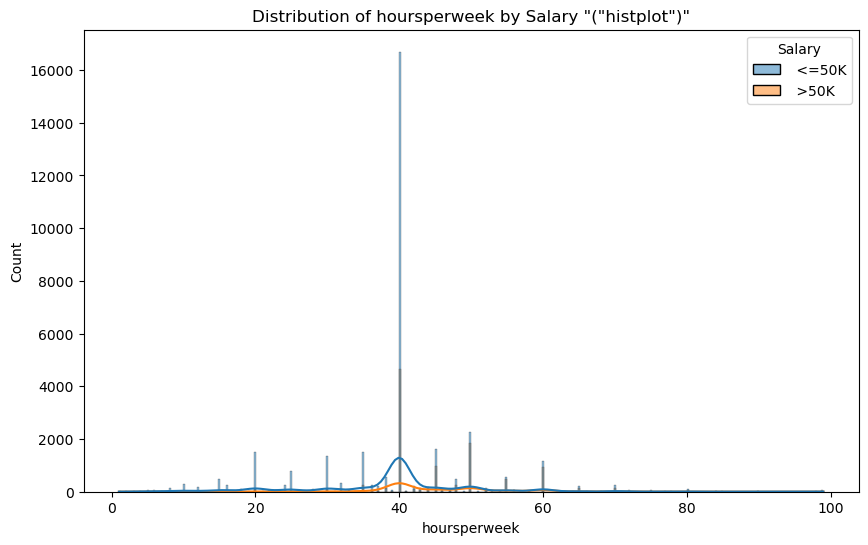

In [2]:
# Distribution of numerical features by Salary
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=combined_data, x=feature, hue='Salary', kde=True)
    plt.title(f'Distribution of {feature} by Salary "("histplot")"')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

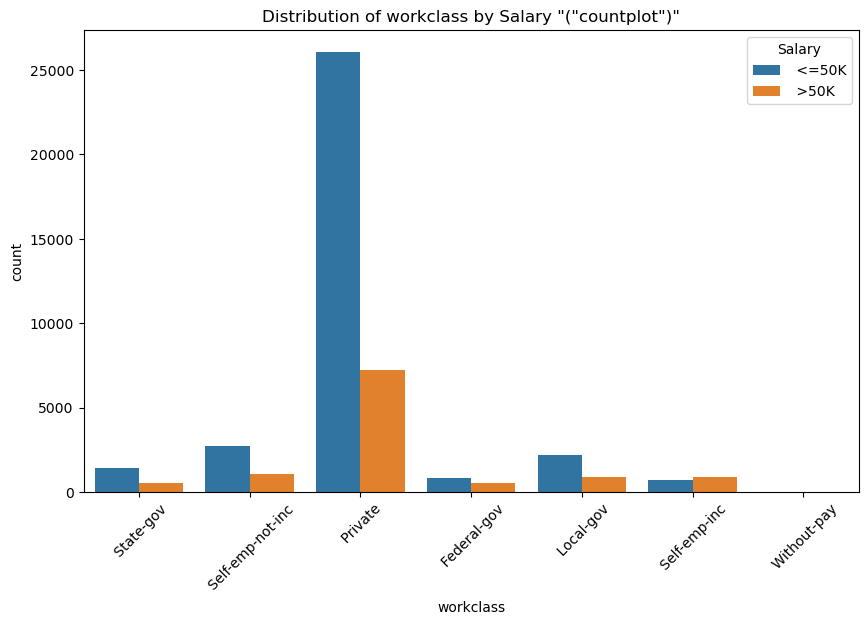

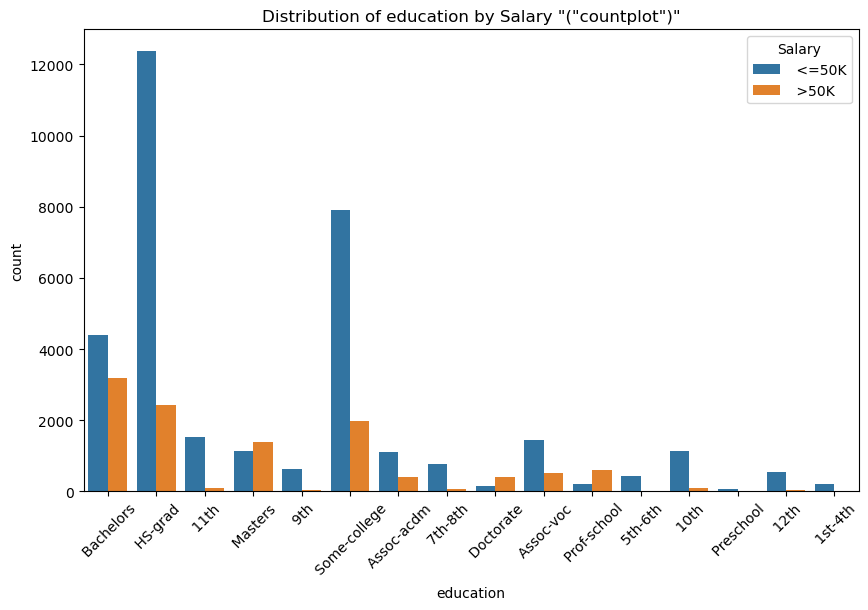

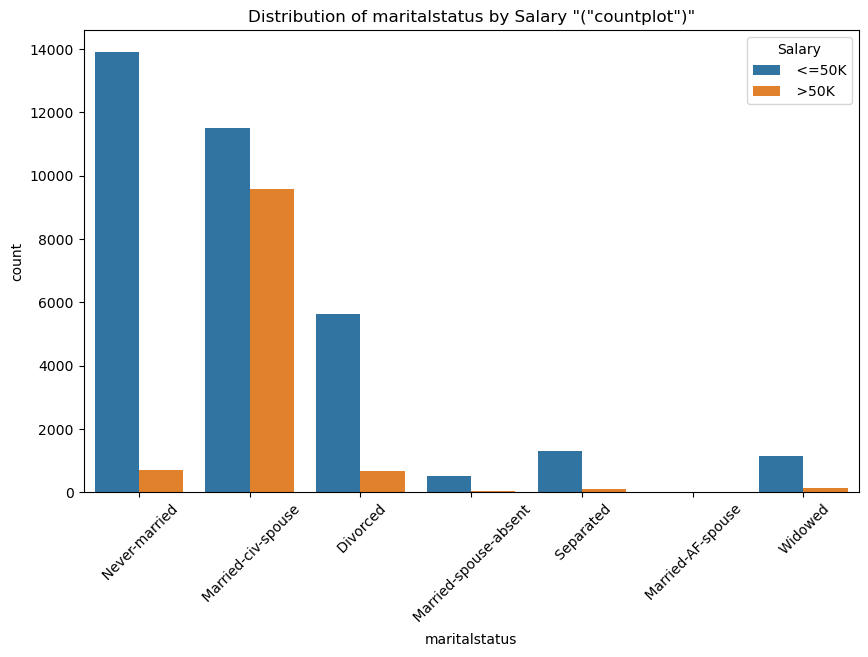

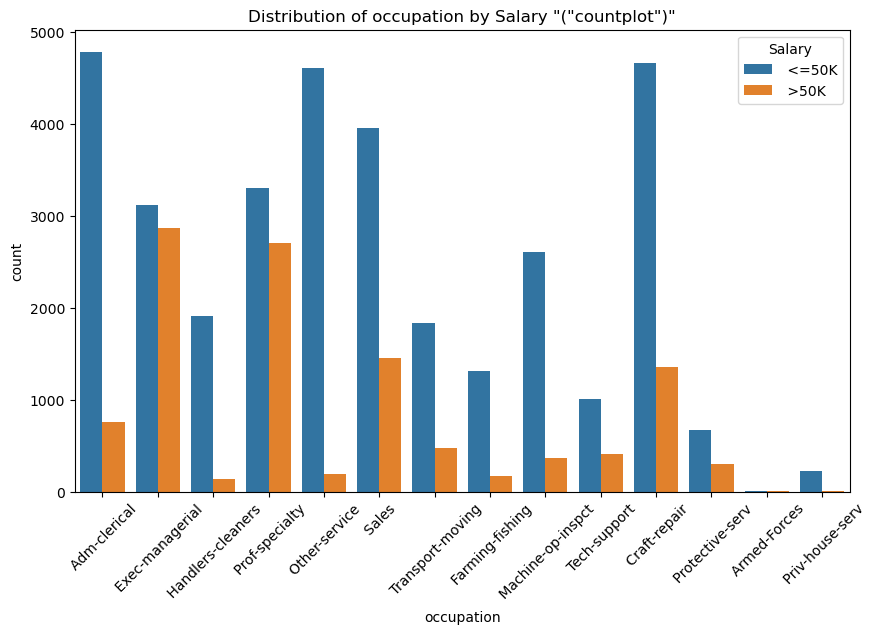

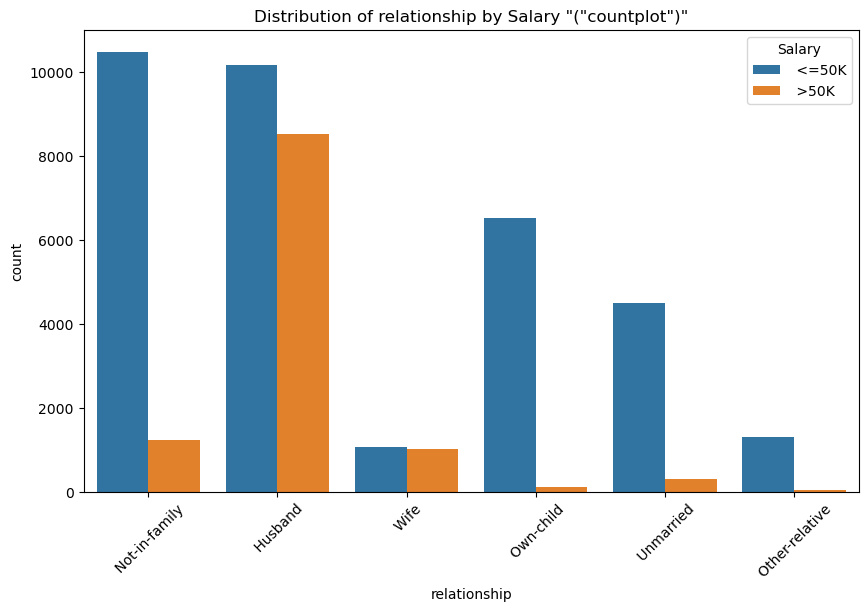

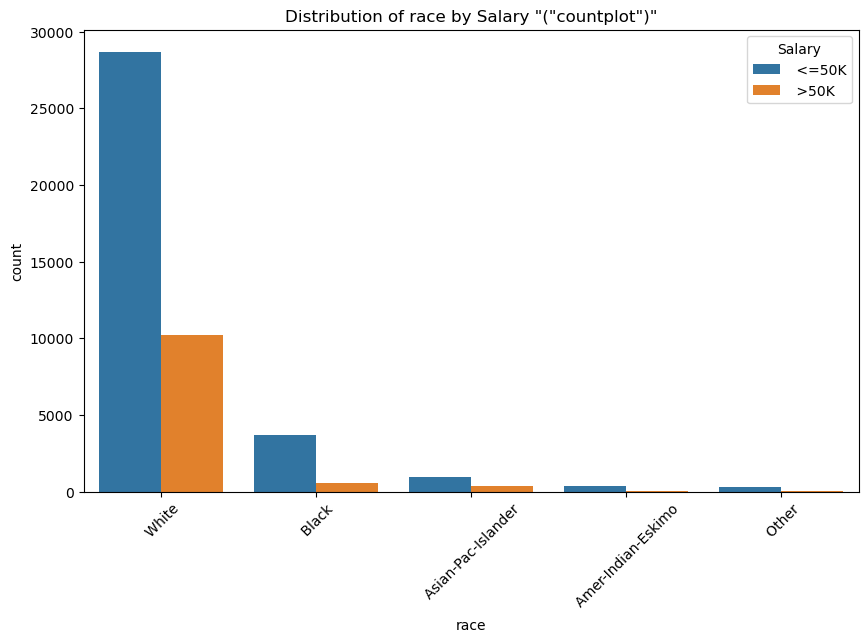

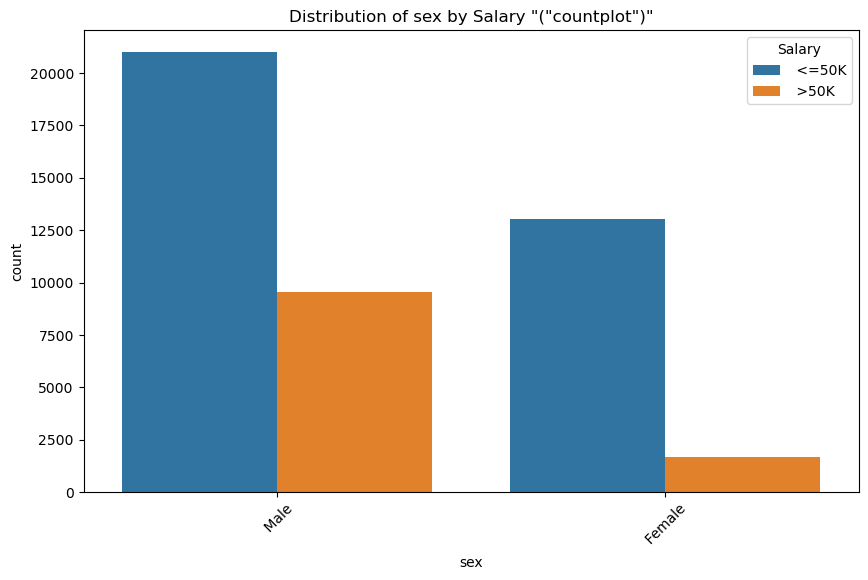

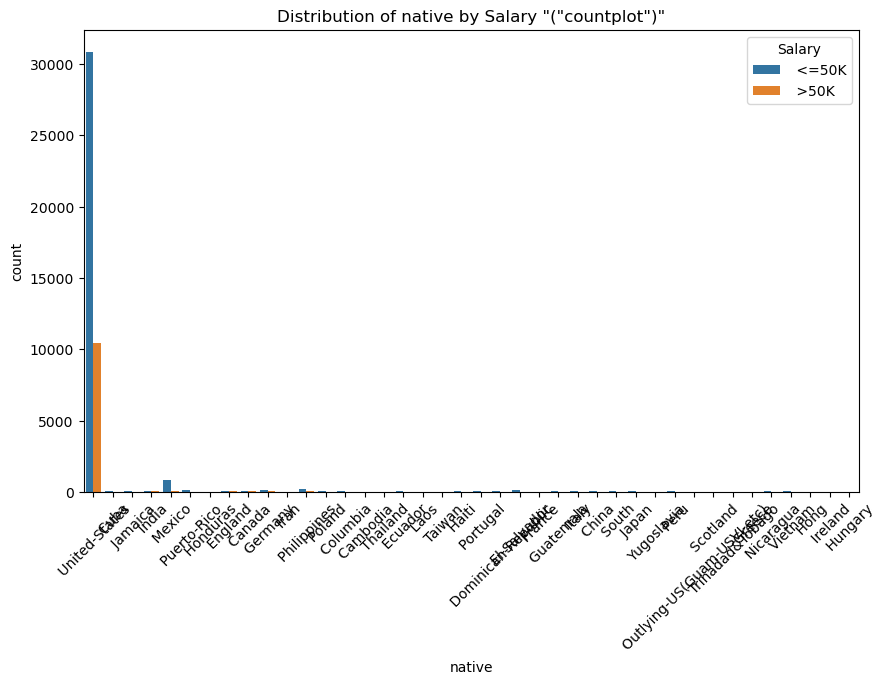

In [3]:
# Count Plots
for feature in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='Salary', data=combined_data)
    plt.title(f'Distribution of {feature} by Salary "("countplot")"')
    plt.xticks(rotation=45)
    plt.show()

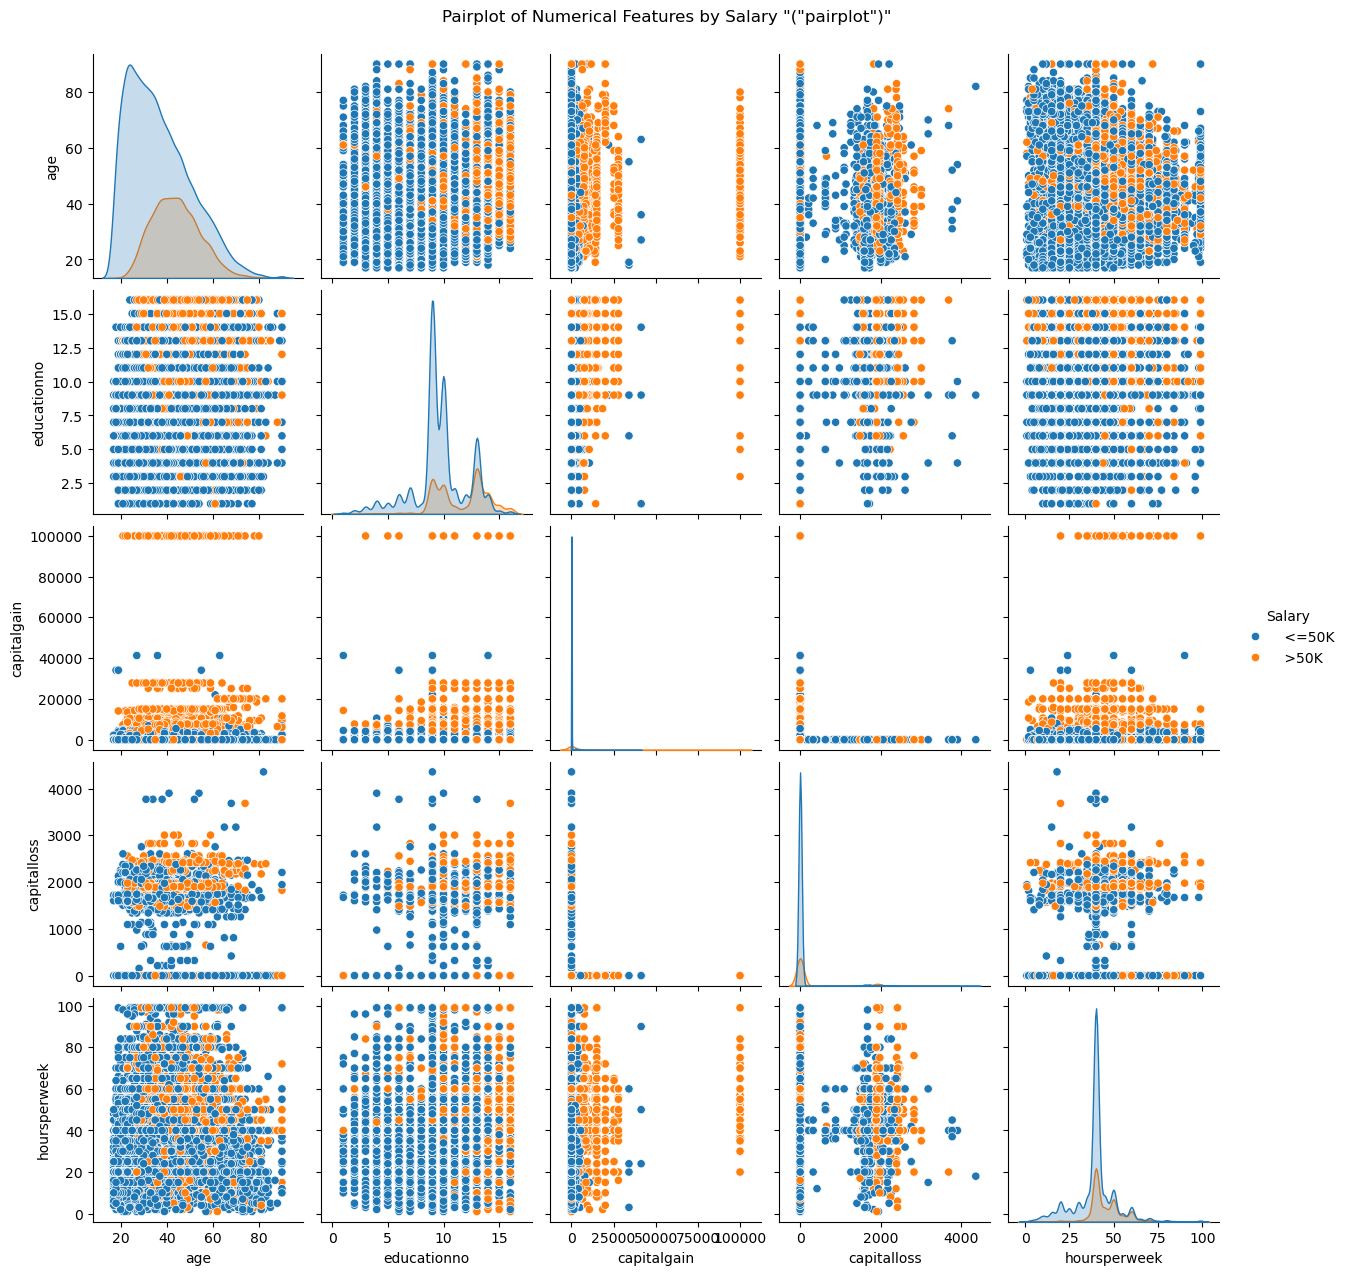

In [4]:
# Pairplot for numerical features
sns.pairplot(combined_data, hue='Salary', diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features by Salary "("pairplot")"', y=1.02)
plt.show()

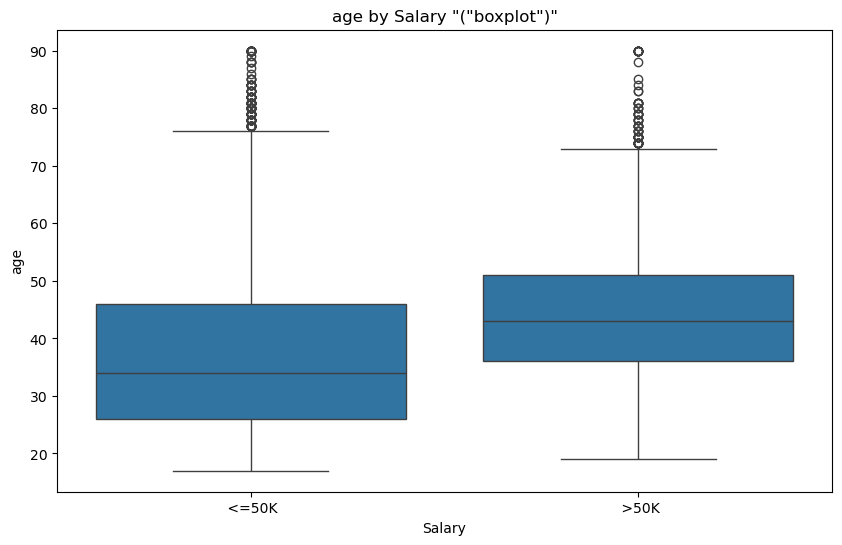

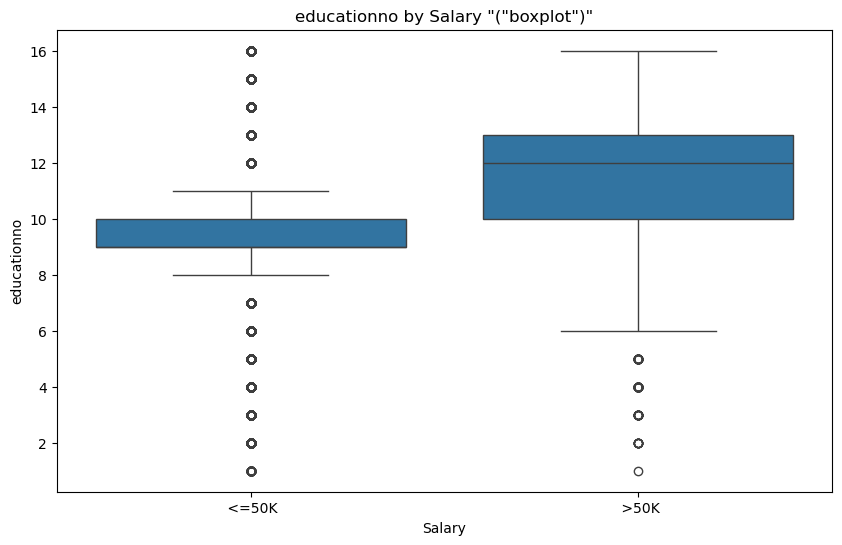

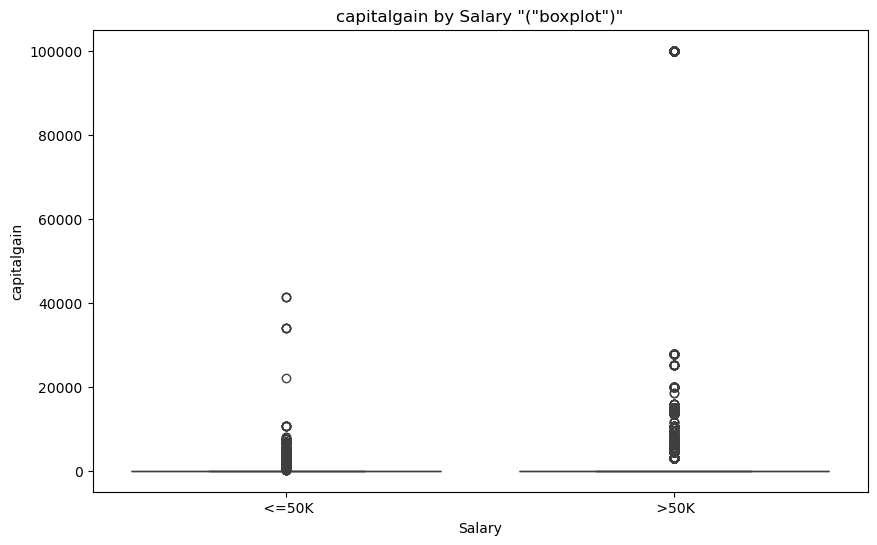

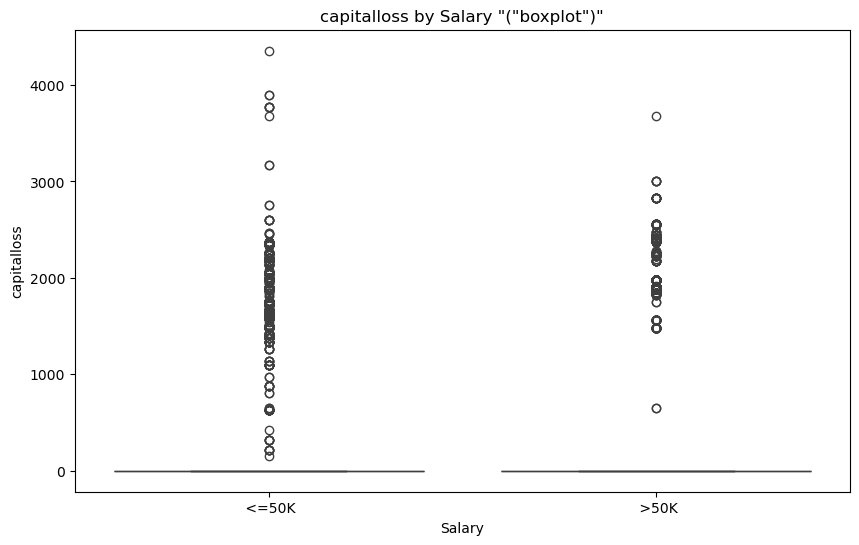

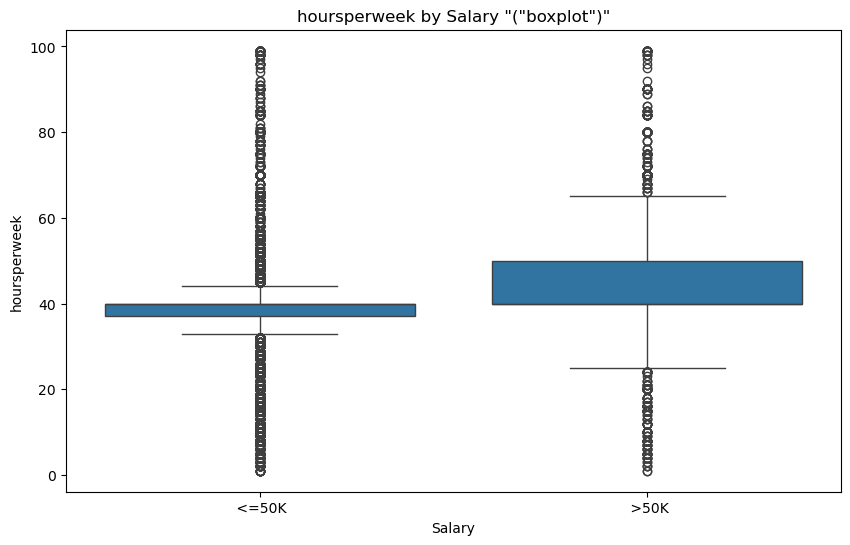

In [5]:
# Boxplot for numerical features by Salary
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Salary', y=feature, data=combined_data)
    plt.title(f'{feature} by Salary "("boxplot")"')
    plt.xlabel('Salary')
    plt.ylabel(feature)
    plt.show()

In [6]:
def remove_outliers_iqr(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

# Remove outliers from combined_data
combined_data = remove_outliers_iqr(combined_data, numerical_features)

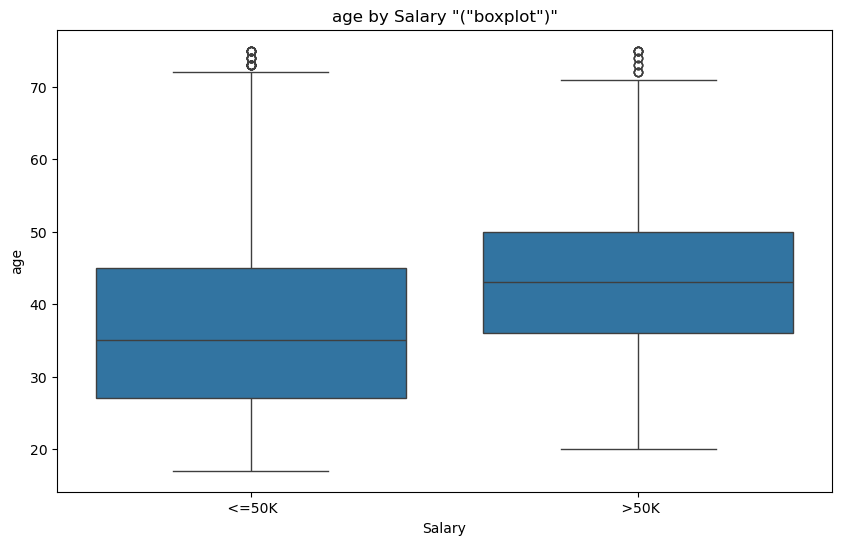

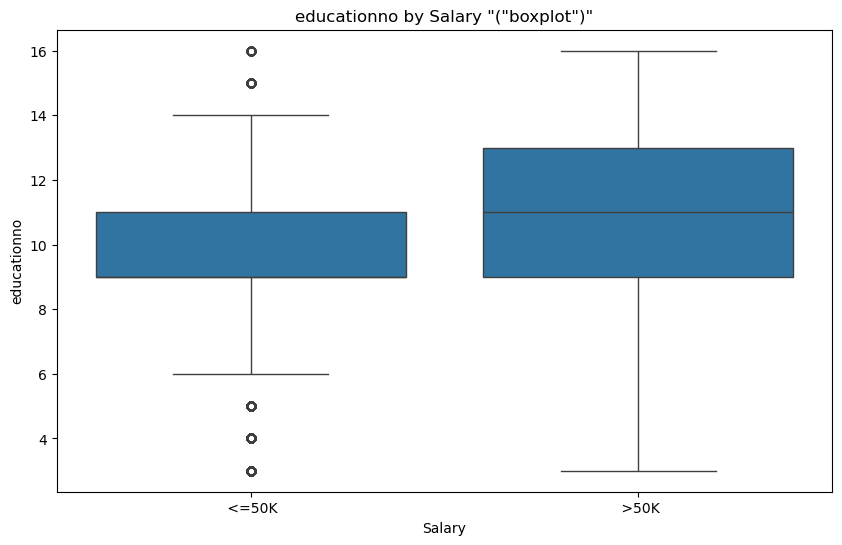

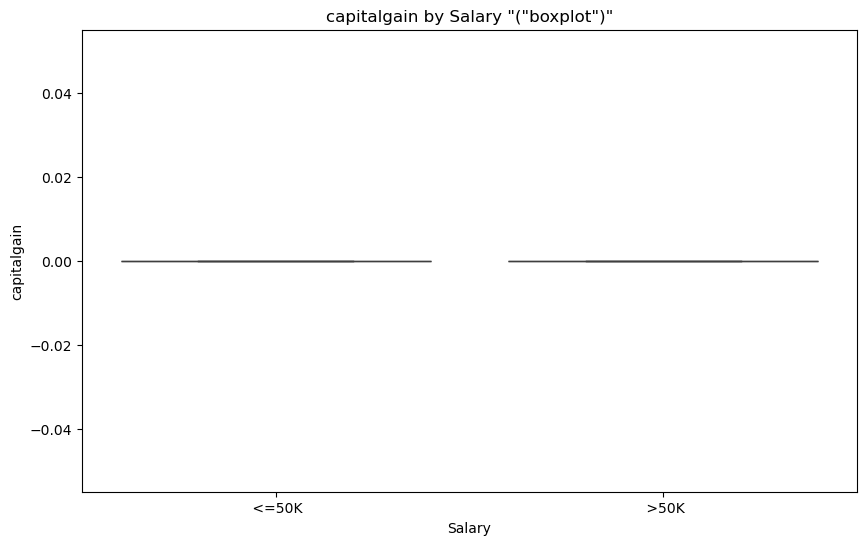

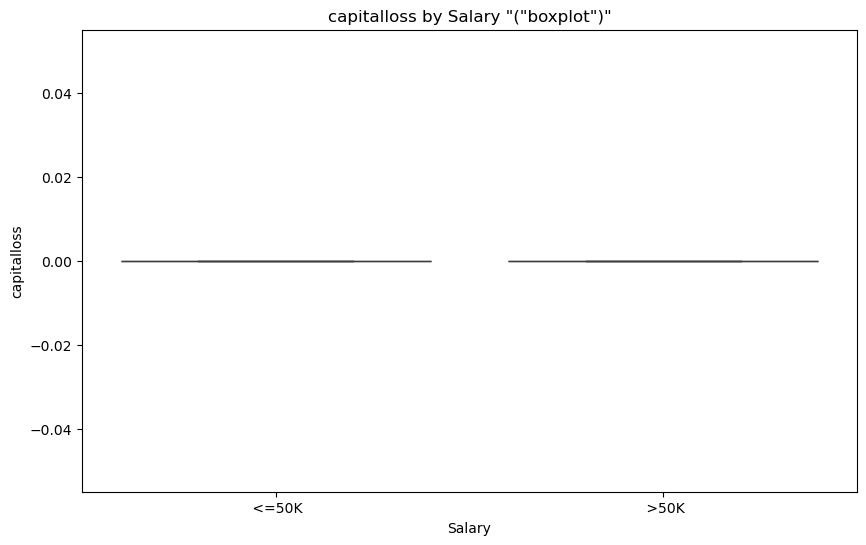

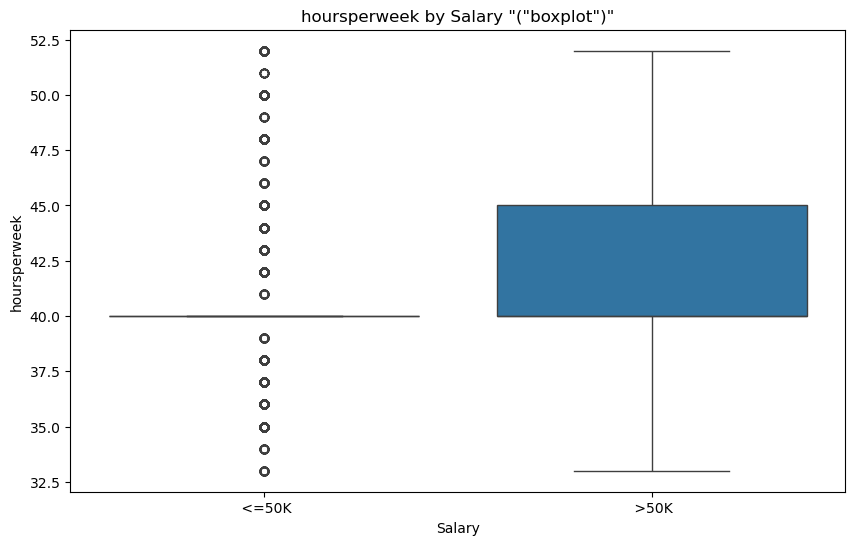

In [7]:
# Visualizing the data after removing outliers

# Boxplot for numerical features by Salary
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Salary', y=feature, data=combined_data)
    plt.title(f'{feature} by Salary "("boxplot")"')
    plt.xlabel('Salary')
    plt.ylabel(feature)
    plt.show()

In [8]:
# Checking value counts for 'capitalgain' column
capitalgain_counts = combined_data['capitalgain'].value_counts()
print("Value counts for 'capitalgain' column:")
print(capitalgain_counts)

# Checking value counts for 'capitalloss' column
capitalloss_counts = combined_data['capitalloss'].value_counts()
print("\nValue counts for 'capitalloss' column:")
print(capitalloss_counts)

Value counts for 'capitalgain' column:
capitalgain
0    28600
Name: count, dtype: int64

Value counts for 'capitalloss' column:
capitalloss
0    28600
Name: count, dtype: int64


In [9]:
# As all the entries in both the 'capitalgain' and 'capitalloss' columns are 0, it might not provide significant information.
# Hence dropping off the columns from the dataset.

# Drop 'capitalgain' and 'capitalloss' columns
combined_data.drop(['capitalgain', 'capitalloss'], axis=1, inplace=True)

numerical_features = [col for col in numerical_features if col not in ['capitalgain', 'capitalloss']]

In [10]:
# Get counts for all columns
column_counts = {}

for column in categorical_columns:
    column_counts[column] = combined_data[column].value_counts()

print("Counts for all columns:")
for column, counts in column_counts.items():
    print(f"\nColumn: {column}")
    print(counts)

Counts for all columns:

Column: workclass
workclass
 Private             21717
 Local-gov            2078
 Self-emp-not-inc     1762
 State-gov            1304
 Federal-gov          1004
 Self-emp-inc          729
 Without-pay             6
Name: count, dtype: int64

Column: education
education
 HS-grad         10253
 Some-college     6066
 Bachelors        4735
 Masters          1423
 Assoc-voc        1358
 Assoc-acdm        990
 11th              846
 10th              756
 7th-8th           514
 9th               477
 12th              339
 5th-6th           323
 Prof-school       285
 Doctorate         235
Name: count, dtype: int64

Column: maritalstatus
maritalstatus
 Married-civ-spouse       13132
 Never-married             8984
 Divorced                  4455
 Separated                 1005
 Widowed                    645
 Married-spouse-absent      361
 Married-AF-spouse           18
Name: count, dtype: int64

Column: occupation
occupation
 Craft-repair         4461
 Adm-cleri

In [11]:
combined_data.describe()

,age,educationno,hoursperweek
count,28600.000000,28600.000000,28600.000000
mean,38.164056,10.064580,41.493741
std,11.861699,2.392788,3.965801
min,17.000000,3.000000,33.000000
25%,29.000000,9.000000,40.000000
50%,37.000000,10.000000,40.000000
75%,47.000000,12.000000,41.000000
max,75.000000,16.000000,52.000000


In [12]:
# Remove leading and trailing spaces from 'Salary' column
combined_data['Salary'] = combined_data['Salary'].str.strip()

# Convert Salary to numerical values
combined_data['Salary'] = combined_data['Salary'].map({'<=50K': 0, '>50K': 1})

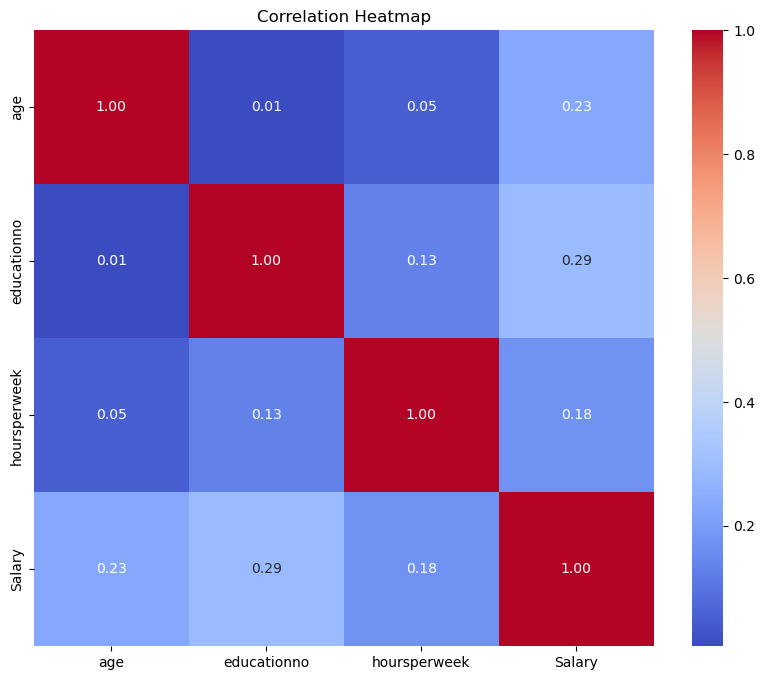

In [13]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(combined_data[numerical_features + ['Salary']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [14]:
# Encoding the categorical columns with LabelEncoder
le = LabelEncoder()

for column in categorical_columns:
    combined_data[column] = le.fit_transform(combined_data[column])

# Select features and target variable for training set
X_train = combined_data.drop('Salary', axis=1)
y_train = combined_data['Salary']

# Split the training data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Define the SVM model
svm_model = SVC()

# Define the grid of hyperparameters to search
param_grid = {
    # Regularization parameter
    'C': [0.1, 1, 10],
    # Kernel type
    'kernel': ['poly', 'rbf', 'sigmoid'],
    # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'gamma': ['scale', 'auto']
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found by grid search:")
print(grid_search.best_params_)

accuracy = grid_search.score(X_test, y_test)
print("Accuracy on test set: {:.2f}%".format(accuracy * 100))

Best parameters found by grid search:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy on test set: 83.23%


Accuracy: 0.83 

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90      6775
           1       0.67      0.39      0.50      1805

    accuracy                           0.83      8580
   macro avg       0.76      0.67      0.70      8580
weighted avg       0.82      0.83      0.81      8580



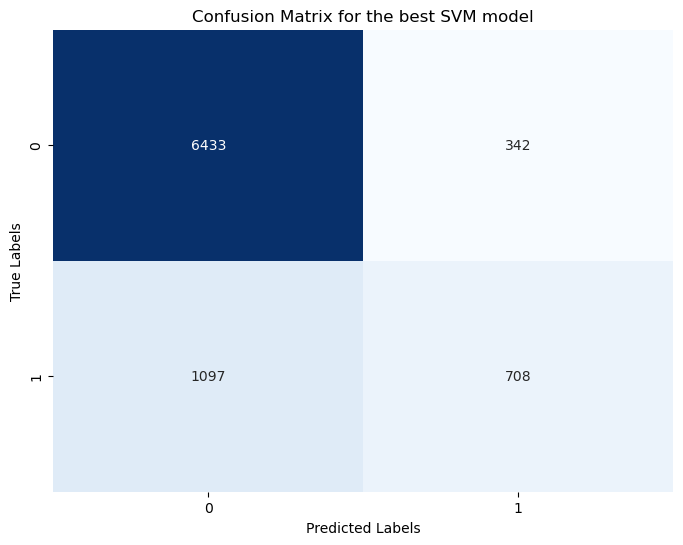

In [16]:
svm_model = grid_search.best_estimator_

# Make predictions
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f} \n")
print(f"Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix for the best SVM model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

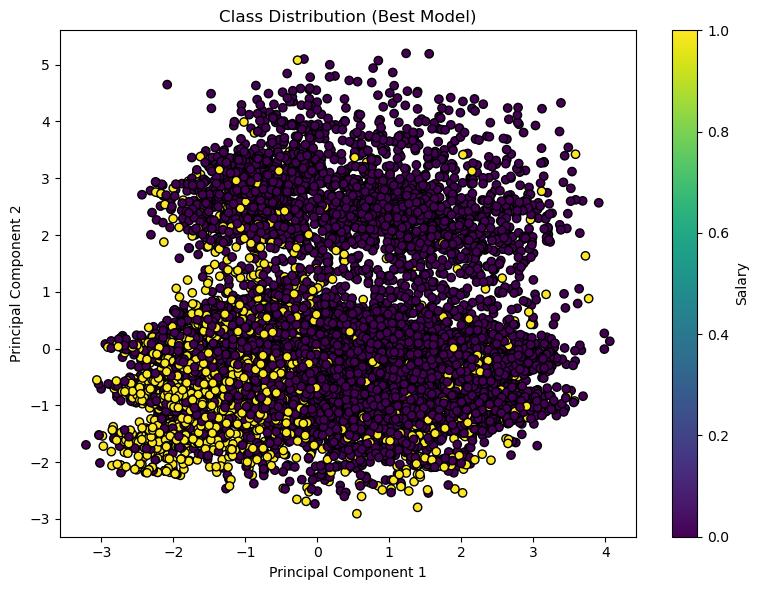

In [18]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Visualize class distribution in reduced-dimensional space
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', marker='o', edgecolors='k')
plt.title(f'Class Distribution (Best Model)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Salary')
plt.tight_layout()
plt.show()